### Monte-Carlo sims for comparing D2D and DNN solution vectors



#### TODO:


Bring cartesian representation of corners back to training data generation file

Break test data into "easy, medium, and hard" scans with varying degrees of perspective shift


In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime

plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": ["Times"],
    "font.size": 12})

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

print(tf.__version__) #requires tensorflow 2.3

%matplotlib notebook
%load_ext tensorboard
%load_ext autoreload
%autoreload 2
%autosave 180

2022-10-23 16:39:01.320031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 16:39:01.417120: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-23 16:39:01.740270: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-23 16:39:01.740312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


2022-10-23 16:39:02.511298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 16:39:02.530385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 16:39:02.530520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Autosaving every 180 seconds


In [2]:
model = tf.keras.models.load_model("CP.kmod") #test
# model = tf.keras.models.load_model("KITTICARLA100.kmod") #best for KITTI CARLA
# model = tf.keras.models.load_model("Net.kmod") # best so far for shadowed ModelNet40 point clouds
# model = tf.keras.models.load_model("SmallNet.kmod") # best for uniform sampling dataset
# model = tf.keras.models.load_model("ModelNet100pts.kmod")
# model = tf.keras.models.load_model("KITTInet.kmod") #50pts, 3cm MAE, trained a while ago...

2022-10-23 16:39:06.764310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 16:39:06.764934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 16:39:06.765086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 16:39:06.765291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
#load test data
d1 = np.load("training_data/compact_scan1.npy")
d2 = np.load("training_data/compact_scan2.npy")
gt = np.load("training_data/ground_truth.npy")
cgt = np.load("training_data/compact_ground_truth.npy")
LUT = np.load("training_data/LUT.npy")
L = np.load("training_data/L.npy")
U = np.load("training_data/U.npy")
corn = np.load("training_data/corn.npy")

#reshape but don't convert to tensor
points_per_sample = 50          #poitns sammpled from each voxel
tsplit = 0.5 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
print(np.shape(x_test))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]

# y_train = gt[:ntrain][:,:,0] #when using compact data
# y_test = gt[ntrain:][:,:,0]
LUT = tf.convert_to_tensor(LUT)[ntrain:]
U = tf.convert_to_tensor(U)[ntrain:]
L = tf.convert_to_tensor(L)[ntrain:]
corn_train = corn[:ntrain]
corn_test = corn[ntrain:]

In [3]:
#load ModelNet40 shadowed data
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan1_320k.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_scan2_320k.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/ModelNet40/100pts_ground_truth_320k.npy")

#load 100pts KITTI skip3 data
d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091_scan1_100pts_skip3.npy")
d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091_scan2_100pts_skip3.npy")
gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091_ground_truth_100pts_skip3.npy")

#load 50pts KITTI noskip 
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091v2_scan1_50pts.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091v2_scan2_50pts.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0091v2_ground_truth_50pts.npy")
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071v2_scan1_50pts.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071v2_scan2_50pts.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_0071v2_ground_truth_50pts.npy")

# #100pts KITTI_CARLA dataset Initial transform  ~ N(0,3)
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# d1 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_01_scan1_100pts.npy")
# d2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_01_scan2_100pts.npy")
# gt = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_01_ground_truth_100pts.npy")

# d1_2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_03_scan1_100pts.npy")
# d2_2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_03_scan2_100pts.npy")
# gt_2 = np.load("/media/derm/06EF-127D1/TrainingData/KITTI_CARLA_03_ground_truth_100pts.npy")

# d1 = np.append(d1, d1_2, axis = 0)
# d2 = np.append(d2, d2_2, axis = 0)
# gt = np.append(gt, gt_2, axis = 0)
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

points_per_sample = 100 #100          #points sampled from each voxel
tsplit = 0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
# print(np.shape(x_test))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]

(262792, 200, 3)


In [ ]:
#load uniformly sampled ModelNet40 data
points_per_sample = 100
# x_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_x_train.npy')
# y_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_y_train.npy')[:,:3]
# x_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_x_test.npy')
# y_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_ModelNet40_y_test.npy')[:,:3]

x_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_x_train.npy')
y_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_y_train.npy')[:,:3]
x_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_x_test.npy')
y_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/full_simple_ModelNet40_y_test.npy')[:,:3]

# x_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/single_ModelNet40_x_train.npy')
# y_train = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/single_ModelNet40_y_train.npy')[:,:3]
# x_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/single_ModelNet40_x_test.npy')
# y_test = np.load('/media/derm/06EF-127D1/TrainingData/ModelNet40/single_ModelNet40_y_test.npy')[:,:3]

print("x_test", np.shape(x_test))
print("y_test", np.shape(y_test))
print(y_test)

In [ ]:
#define functions to convert between spherical and cartesian coordinate representations
def c2s(pts):
    """ converts points from cartesian coordinates to spherical coordinates """
    r = tf.sqrt(pts[:,0]**2 + pts[:,1]**2 + pts[:,2]**2)
    phi = tf.math.acos(pts[:,2]/r)
    theta = tf.math.atan2(pts[:,1], pts[:,0])

    out = tf.transpose(tf.Variable([r, theta, phi]))
    return(out)
def s2c(pts):
    """converts spherical -> cartesian"""

    x = pts[:,0]*tf.math.sin(pts[:,2])*tf.math.cos(pts[:,1])
    y = pts[:,0]*tf.math.sin(pts[:,2])*tf.math.sin(pts[:,1]) 
    z = pts[:,0]*tf.math.cos(pts[:,2])

    out = tf.transpose(tf.Variable([x, y, z]))
    # out = tf.Variable([x, y, z])
    return(out)

### Iterative solution for single test sample

In [ ]:
# n = int(np.floor(500*np.random.rand()))
n = 343
print(n)

c1 = np.array([x_test[n,:points_per_sample,0], x_test[n,:points_per_sample,1], x_test[n,:points_per_sample,2]])
c2 = np.array([x_test[n,points_per_sample:,0], x_test[n,points_per_sample:,1], x_test[n,points_per_sample:,2]])

inputs = x_test[n][None,:]
runlen = 10
corr_sum = np.zeros([1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
#     correction = correction*0.1 #for synthetic matab data only??
#     correction = y_test[n] #show actual solution
    corr_sum += correction
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]

print("\n correct soln", y_test[n])
print("\n estiamted soln:", corr_sum)
print("\n error from DNN:", y_test[n] - corr_sum)
mean1 = np.mean(x_test[n,:points_per_sample], axis = 0)
mean2 = np.mean(x_test[n,points_per_sample:], axis = 0)
print("\n error in means",  y_test[n] + (mean1 - mean2))

In [ ]:
#use Vedo to plot inital and transformed point clouds in 3D 
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

plt1 = Plotter(N = 1, axes = 13, bg = (1, 1, 1), interactive = True)
disp = []

#draw scan1 
# disp.append(Points(x_test[n,:points_per_sample].numpy(), c = 'green', r = 5))
disp.append(Points(x_test[n,:points_per_sample], c = 'red', r = 5))

#draw initial scan2
# disp.append(Points(x_test[n,points_per_sample:].numpy(), c = 'red', r = 5))
disp.append(Points(x_test[n,points_per_sample:], c = 'blue', r = 5))

#Draw arrow for ground truth soln vec
# disp.append(Arrow(mean1 + y_test[n], mean1, c = 'y4', s = 0.002, res = 100)) #arbitrarily start arrow from scan1 center
disp.append(Arrow(mean2, mean2 - y_test[n], c = 'y4', s = 0.002, res = 100))

#draw ground truth arrow cut short by U and L
soln_compact = tf.matmul(LUT[n], y_test[n][:, None])
soln_compact_xyz = tf.matmul(U[n], soln_compact)[:,0]
soln_compact_xyz = tf.matmul(tf.transpose(U[n]), soln_compact)[:,0]
print("soln_compact_xyz: \n", soln_compact_xyz)
disp.append(Arrow( mean2, mean2 - soln_compact_xyz, c = 'p4', s = 0.002, res = 100)) #arbitrarily start arrow from scan1 center

#draw the set of 8 points that defined the voxel boundaries for the keyframe scan
corn_cart = s2c(corn_test[n])
# disp.append(Points(corn_cart, c = 'black', r = 10))

#draw box instead of individual points______________________________
p1, p2, p3, p4, p5, p6, p7, p8 = corn_cart.numpy()
# print(p1)
# print(p2)
lineWidth = 2
c1 = "black"

arc1 = shapes.Line(p1, p2, c = c1, lw = lineWidth) 
disp.append(arc1)
arc2 = shapes.Line(p3, p4, c = c1, lw = lineWidth) #debug
disp.append(arc2)
line1 = shapes.Line(p1, p3, c = c1, lw = lineWidth)
disp.append(line1)
line2 = shapes.Line(p2, p4, c = c1, lw = lineWidth) #problem here
disp.append(line2)
arc3 = shapes.Line(p5, p6, c = c1, lw = lineWidth) #debug
disp.append(arc3)
arc4 = shapes.Line(p7, p8, c = c1, lw = lineWidth) #debug
disp.append(arc4)
line3 = shapes.Line(p5, p7, c = c1, lw = lineWidth)
disp.append(line3)
line4 = shapes.Line(p6, p8, c = c1, lw = lineWidth)
disp.append(line4)
disp.append(shapes.Line(p1,p5, c = c1, lw = lineWidth))
disp.append(shapes.Line(p2,p6, c = c1, lw = lineWidth))
disp.append(shapes.Line(p3,p7, c = c1, lw = lineWidth))
disp.append(shapes.Line(p4,p8, c = c1, lw = lineWidth))
#_____________________________________________________________________

#draw transformed scan2
# disp.append(Points(c1, c = 'blue', r = 5))

plt1.show(disp, "Network Performance Test")
ViewInteractiveWidget(plt1.window)


### Run network on all test data 
# RUN TESTS HERE

In [4]:
# for n in range(numToTest):
c1 = np.array([x_test[:,:points_per_sample,0], x_test[:,:points_per_sample,1], x_test[:,:points_per_sample,2]])
c2 = np.array([x_test[:,points_per_sample:,0], x_test[:,points_per_sample:,1], x_test[:,points_per_sample:,2]])
c1 = np.transpose(c1, (1,2,0))
c2 = np.transpose(c2, (1,2,0))

inputs = x_test
# print("c1" , tf.shape(c1))
print("x_test" , tf.shape(x_test))
print("y_test" , tf.shape(y_test))

runlen = 2
corr_sum = np.zeros([tf.shape(x_test)[0].numpy(),1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[:,None,:] #show what the network thinks
#     correction = correction*0.1 #for synthetic matab data only??
#     correction = y_test[n] #show actual solution
    corr_sum += correction
#     print("corr_sum", tf.shape(corr_sum))
    c1 += correction
#     print("after correction", tf.shape(c1))
    inputs = np.append(c1, c2, axis = 1)#.T
#     print("\n new inputs", tf.shape(inputs))
    
dnn_estimates = corr_sum[:,0,:]
print("\n correct soln \n", y_test)
print("\n estiamted soln: \n", dnn_estimates)
print("\n error from DNN: \n", y_test - dnn_estimates)

# print("\n mean raw DNN error: \n", np.sqrt(np.sum(np.mean(np.abs(y_test - dnn_estimates), axis = 0)**2)))
print("\n mean raw DNN error: \n", np.sqrt(np.mean(np.abs(y_test - dnn_estimates), axis = 0)**2))

D2D_distance = np.mean(x_test[:,:points_per_sample], axis = 1) - np.mean(x_test[:,points_per_sample:], axis = 1)
# print(tf.shape(D2D_distance))
# print(tf.shape(y_test))
# print("\n mean raw D2D error \n", np.sqrt(np.sum(np.mean(np.abs(y_test + D2D_distance), axis = 0)**2 )))
print("\n mean raw D2D error \n", np.sqrt(np.mean(np.abs(y_test + D2D_distance), axis = 0)**2 ))

x_test tf.Tensor([13832   200     3], shape=(3,), dtype=int32)
y_test tf.Tensor([13832     3], shape=(2,), dtype=int32)


2022-10-23 16:39:20.527615: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


 96/433 [=====>........................] - ETA: 0s

2022-10-23 16:39:20.805618: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-23 16:39:20.830527: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


433/433 [==============================] - 1s 2ms/step

 correct soln 
 [[ 0.14219274 -1.6396886  -0.00573922]
 [ 0.45314926  0.6857338   0.09654721]
 [ 1.1230043  -0.3386279  -0.04164533]
 ...
 [-0.66419196  1.9431598  -0.00353422]
 [ 0.80967206  0.22453983 -0.20343618]
 [-1.0606884  -1.7160267   0.06226724]]

 estiamted soln: 
 [[ 0.02885019 -1.6964762  -0.0046452 ]
 [ 0.3879511   0.66452393  0.09735412]
 [ 1.07026178 -0.43796172 -0.03015345]
 ...
 [-0.66103201  1.89245708 -0.01414474]
 [ 0.76319976  0.2647178  -0.21772952]
 [-1.05836456 -1.79558248  0.04936097]]

 error from DNN: 
 [[ 0.11334254  0.05678759 -0.00109402]
 [ 0.06519816  0.02120987 -0.00080691]
 [ 0.05274254  0.09933381 -0.01149188]
 ...
 [-0.00315995  0.05070274  0.01061052]
 [ 0.0464723  -0.04017797  0.01429334]
 [-0.00232382  0.07955582  0.01290627]]

 mean raw DNN error: 
 [0.0354009  0.04846045 0.01538405]

 mean raw D2D error 
 [0.04427612 0.05247677 0.02010326]


<IPython.core.display.Javascript object>


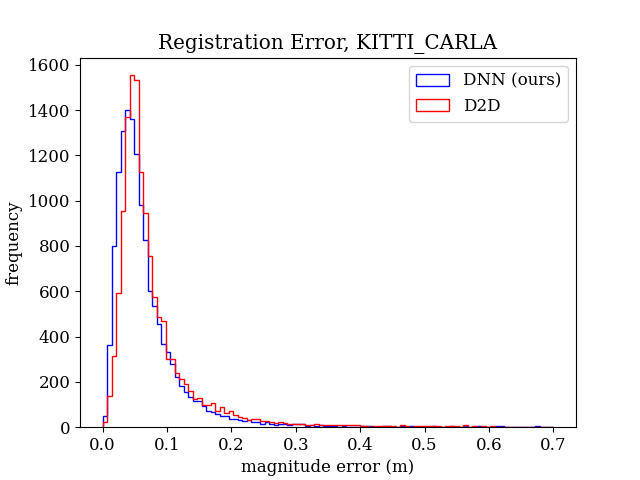

In [5]:
#plot histogram of distribution of errors from DNN (is it even gaussian??)

dnn_error = y_test - dnn_estimates
D2D_error = y_test + D2D_distance
mag_D2D = np.sqrt(D2D_error[:,0]**2 + D2D_error[:,1]**2 + D2D_error[:,2]**2)
mag_DNN = np.sqrt(dnn_error[:,0]**2 + dnn_error[:,1]**2 + dnn_error[:,2]**2)
num_bins = 100

#plot on same axis ---------------------------------------
fig, ax = plt.subplots()
# ax.set_title("x component of registration error")
# R = [-0.5,0.5] #range
# ax.hist(dnn_error[:,0], num_bins, R, histtype='step', fill=False, color = (0,0,1), label = 'DNN (ours)')
# ax.hist(D2D_error[:,0], num_bins, R, histtype='step', fill=False, color = (1,0,0), label = 'D2D')
ax.set_title("Registration Error, KITTI_CARLA")
# ax.set_title("Registration Error, Shadowed ModelNet40 Dataset")
# ax.set_title("Registration Error, Uniformly Sampled ModelNet40 Dataset")
R = [0, 0.7]
ax.hist(mag_DNN, num_bins, R, histtype='step', fill=False, color = (0,0,1), label = 'DNN (ours)')
ax.hist(mag_D2D, num_bins, R, histtype='step', fill=False, color = (1,0,0), label = 'D2D')
# ax.set_xlim([0,0.5])
ax.set_ylabel('frequency')
ax.set_xlabel('magnitude error (m)')
ax.legend(loc = 'best')
#---------------------------------------------------------

# #seprate plots------------------------------------------
# fig, ax = plt.subplots(2,1)
# ax[0].set_ylabel('frequency')
# ax[0].set_xlabel('x component of translation error (m)')
# ax[0].set_title('DNN (ours)')
# ax[0].hist(dnn_error[:,0], num_bins);
# ax[0].set_xlim([-0.5,0.5])

# ax[1].set_title('D2D')
# ax[1].set_ylabel('frequency')
# ax[1].set_xlabel('x component of translation error (m)')
# ax[1].hist(D2D_error[:,0], num_bins*3)
# ax[1].set_xlim([-0.5,0.5])
# #-------------------------------------------------------

<IPython.core.display.Javascript object>


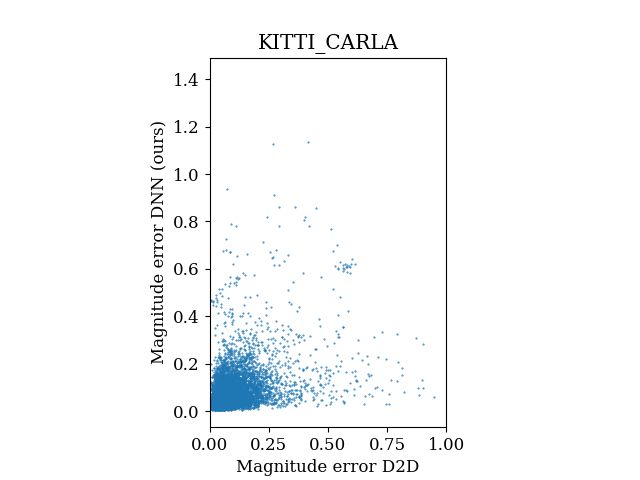


 mean magnitude D2D: 0.08236929

 mean magnitude DNN 0.07004181723585705

 cov mag D2D: 0.08490202744004594

 cov mag DNN: 0.07124113380632006


In [6]:
#plot relationship between error in D2D and error in DNN
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Magnitude error D2D')
# ax.set_xlabel('$\Delta_{D2D}$') #nope
ax.set_xlim([0,1])
ax.set_ylabel('Magnitude error DNN (ours)')
ax.set_title("KITTI_CARLA")

ax.scatter(mag_D2D, mag_DNN, alpha = 1, s = 0.2)

c = np.cov(mag_D2D, mag_DNN)

print("\n mean magnitude D2D:", np.mean(mag_D2D))
print("\n mean magnitude DNN", np.mean(mag_DNN))
print("\n cov mag D2D:", np.sqrt(c)[0,0])
print("\n cov mag DNN:", np.sqrt(c)[1,1])

In [ ]:
#demonstrate using |D2D-DNN| as a monitor statistic

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Actual D2D Error (unobservable)')
ax.set_ylabel('Magnitude Difference Between D2D and DNN')
# ax.set_xlabel('$\Delta_{D2D}$') #nope
# ax.set_xlim([0,1])
ax.set_title("KITTI")

# print(D2D_distance[:10])
# print(dnn_estimates[:10])
Diff= dnn_estimates  +  D2D_distance
mag_Diff = np.sqrt(Diff[:,0]**2 + Diff[:,1]**2 + Diff[:,2]**2)

D2D_error = y_test + D2D_distance
mag_D2D = np.sqrt(D2D_error[:,0]**2 + D2D_error[:,1]**2 + D2D_error[:,2]**2)
# print(y_test)
# print(D2D_distance)
# print(D2D_error)

ax.scatter(mag_D2D, mag_Diff, alpha = 1, s = 0.2)
# ax.plot(np.linspace(0,1,50),np.linspace(0,1,50), color = (1,0,0)) #plot y=x (for debug)


c = np.cov(mag_D2D, mag_Diff)
print(c)

In [ ]:
#just considering the residuals doesn't tell the whole story 
#   we need to consider error in COMPACT only directions

#use LUT to get compact axis of DNN solution vec for each trial
dnn_compact = tf.matmul(LUT, dnn_estimates[:,:,None])
dnn_compact_xyz = tf.matmul(U, dnn_compact)

#for distrubution means distance
d2d_compact = tf.matmul(LUT, D2D_distance[:,:,None])
d2d_compact_xyz = tf.matmul(U, d2d_compact)

truth_compact = tf.matmul(LUT, y_test[:,:,None])
truth_compact_xyz = tf.matmul(U, truth_compact)

# error_DNN_compact = np.sqrt(np.sum( np.mean(np.abs(truth_compact_xyz - dnn_compact_xyz), axis = 0)**2 ))
error_DNN_compact = np.sqrt( np.mean(np.abs(truth_compact_xyz - dnn_compact_xyz), axis = 0)**2 )[:,0]
print("\n mean compact error DNN: \n", error_DNN_compact)

# error_D2D_compact = np.sqrt(np.sum( np.mean(np.abs(truth_compact_xyz + d2d_compact_xyz), axis = 0)**2 ))
error_D2D_compact = np.sqrt(np.mean(np.abs(truth_compact_xyz + d2d_compact_xyz), axis = 0)**2 )[:,0]
print("\n mean compact error D2D: \n", error_D2D_compact)



In [ ]:
s2c(corn_test[n])